# Basic demonstration of creating and using a bright star mask
### Author: Adam D. Myers, University of Wyoming

## Preliminaries

Make sure that you have the following cloned from github:

```
git clone https://github.com/desihub/desispec
git clone https://github.com/desihub/desitarget
git clone https://github.com/desihub/desiutil
```

and make sure that the relevant code from these repositories are in your path and pythonpath (for example):

```
export PYTHONPATH=/global/homes/a/adamyers/git/desispec/py:$PYTHONPATH
export PATH=/global/homes/a/adamyers/git/desispec/bin:$PATH
export PYTHONPATH=/global/homes/a/adamyers/git/desitarget/py:$PYTHONPATH
export PATH=/global/homes/a/adamyers/git/desitarget/bin:$PATH
export PYTHONPATH=/global/homes/a/adamyers/git/desiutil/py:$PYTHONPATH
export PATH=/global/homes/a/adamyers/git/desiutil/bin:$PATH
```

Also retrieve a sample of the sweeps files, say, everything in DR3 that starts sweep-150. I'll assume you put this in your home directory e.g. at NERSC:

```
mkdir ~/sweep150
cp /global/project/projectdirs/cosmo/data/legacysurvey/dr3/sweep/3.1/sweep-150* ~/sweep150
```

## Creating a bright star mask from a sweep-like file or files at the command line

To create a bright star mask by scraping bright stars from the sweeps:

```
make_star_mask ~/sweep150 ~/starmask150.fits 
```

this mask will use default settings and create masks for everything that is brighter than 10th magnitude in each of the *g*, *r* and *z* bands. You can also customize the limiting magnitude of stars to be masked, e.g.:

```
make_star_mask ~/sweep150 --bands GZ --maglim 9,10 ~/starmask150.fits
```

will mask any star that is brighter than *g* < 9 or *z* < 10.

## Plotting masks

Let's examine the mask and plot it. Note that ```NEAR_RADIUS``` is a warning that you're near a mask (which could be useful for large-scale structure analyses) whereas ```IN_RADIUS``` is the radius to which DESI will certainly *not* place any fibers.


In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from desitarget import brightstar, desi_mask
import fitsio
import os

In [119]:
starmask = fitsio.read("~/starmask150.fits")

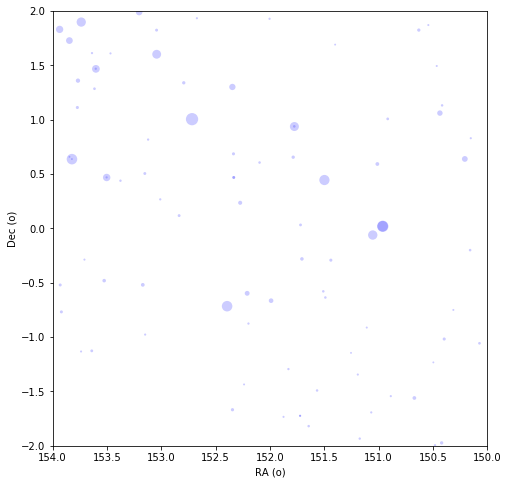

In [120]:
brightstar.plot_mask(starmask,limits=[154,150,-2,2])

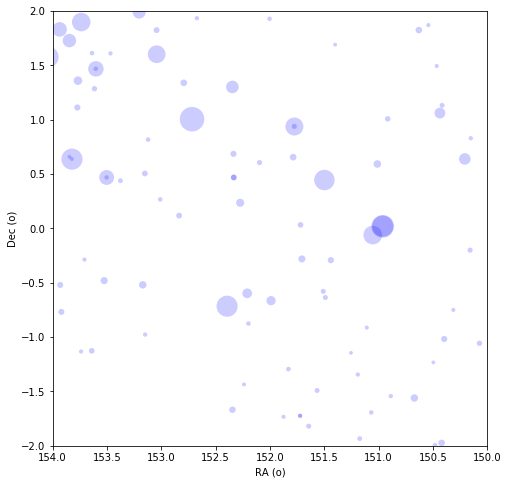

In [121]:
brightstar.plot_mask(starmask,limits=[154,150,-2,2],radius="NEAR_RADIUS")

## Creating a file of targets and masking at the command line

Now let's compile a file of targets from the same set of sweeps. Again, I'll dump the targets file in you home 
directory. This could take a few minutes:

```
select_targets ~/sweep150 ~/targs150.fits
```

Note that at NERSC, the whole masking procedure can be achieved using:

```
select_targets ~/sweep150 ~/targs150.fits --starmask ~/starmask150.fits
```

but that formalism (currently) requires Data Release ```survey-brick``` files to be available in a ```/project/projectdirs/cosmo/data/legacysurvey/``` directory. Instead, here, we'll use the targets file to directly import and demonstrate some of the useful masking functions.

## Generating ```BADSKY``` ("safe") locations

First, let's generate ```BADSKY``` ("safe") locations around the periphery of each mask and plot them against the backdrop of the mask. Note that ```drstring```, if set, is used to assign the Data Release (DR) bit to ```BADSKY``` targets and to assign ```BADSKY``` targets an ```OBJID``` that is higher than any target in a given brick of that DR. (That's the part that requires a DR ```survey-brick``` file, though).

In [122]:
targs = fitsio.read("~/targs150.fits")
print(len(targs))
print(len(np.where( (targs["DESI_TARGET"] & desi_mask.BADSKY) != 0 )[0]))

1332236
0


In [123]:
targs = brightstar.append_safe_targets(targs,starmask,drstring=None)
print(len(targs))
print(len(np.where( (targs["DESI_TARGET"] & desi_mask.BADSKY) != 0 )[0]))

1339210
6974


In [124]:
w = np.where( (targs["DESI_TARGET"] & desi_mask.BADSKY) != 0 )
badskies= targs[w]

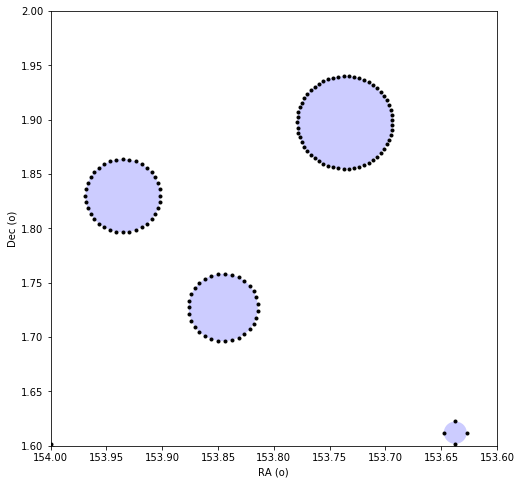

In [125]:
plt.figure(figsize=(8,8))
plt.axis([154,153.6,1.6,2])
plt.plot(badskies["RA"],badskies["DEC"],'k.')
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
brightstar.plot_mask(starmask,over=True)

## Masking targets

Our targets will already have ```DESI_TARGET``` bits set (indicating whether something is an LRG, ELG, QSO etc.) but we can update those bits to indicate which targets are in or are not in a mask. The ```IN_BRIGHT_OBJECT``` bit in ```DESI_TARGET``` indicates whether something is in a mask.

In [126]:
desi_mask

desi_mask:
  - [LRG,              0, "LRG", {'priorities': {'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200, 'DONOTOBSERVE': 1, 'UNOBS': 3200, 'DONE': 1, 'OBS': 1}, 'obsconditions': 'DARK'}]
  - [ELG,              1, "ELG", {'priorities': {'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000, 'DONOTOBSERVE': 1, 'UNOBS': 3000, 'DONE': 1, 'OBS': 1}, 'obsconditions': 'DARK|GRAY'}]
  - [QSO,              2, "QSO", {'priorities': {'MORE_ZWARN': 3400, 'MORE_ZGOOD': 3500, 'DONOTOBSERVE': 1, 'UNOBS': 3400, 'DONE': 1, 'OBS': 1}, 'obsconditions': 'DARK'}]
  - [LRG_NORTH,        8, "LRG from Bok/Mosaic data", {'priorities': {'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200, 'DONOTOBSERVE': 1, 'UNOBS': 3200, 'DONE': 1, 'OBS': 1}, 'obsconditions': 'DARK'}]
  - [ELG_NORTH,        9, "ELG from Bok/Mosaic data", {'priorities': {'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000, 'DONOTOBSERVE': 1, 'UNOBS': 3000, 'DONE': 1, 'OBS': 1}, 'obsconditions': 'DARK|GRAY'}]
  - [QSO_NORTH,       10, "QSO from Bok/Mosaic data", {'priorities': {'MORE_ZWARN'

In [127]:
dt = brightstar.set_target_bits(targs,starmask)
inmask = np.where( (dt & desi_mask.IN_BRIGHT_OBJECT) != 0) 
masked = targs[inmask]
notinmask = np.where( (dt & desi_mask.IN_BRIGHT_OBJECT) == 0) 
unmasked = targs[notinmask]

Let's plot which objects are in masks and which are not, against the backdrop of the mask (in a small region of the sky):

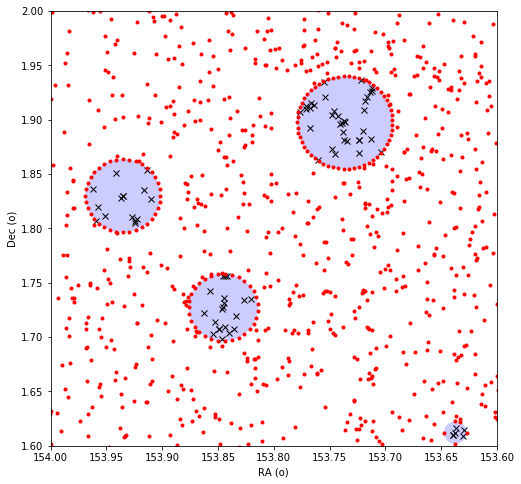

In [128]:
plt.figure(figsize=(8,8))
plt.axis([154,153.6,1.6,2])
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.plot(masked["RA"],masked["DEC"],'kx')
plt.plot(unmasked["RA"],unmasked["DEC"],'r.')
brightstar.plot_mask(starmask,over=True)

Note that the ```BADSKY``` locations are just outside the perimeter of the masks, and are quite obvious in the plot.

## Masking a random catalog

The ```brightstar.set_target_bits()``` function wraps the main masking code in ```brightstar```, called ```is_in_bright_star()```. The ```is_in_bright_star()``` function can be used to compare coordinate locations to a mask and return which objects are in the mask (within the ```IN_RADIUS``` of the mask) and which objects are close to the mask (within the ```NEAR_RADIUS``` of the mask).

Let's create a random catalog over the small area of sky that we've been considering (153.6<sup>o</sup> < RA < 154.0<sup>o</sup>) and (1.6<sup>o</sup> < Dec < 2.0<sup>o</sup>):

In [129]:
from numpy.random import random
Nran = 100000
rancat = np.zeros(Nran, dtype=[('RA', '>f8'), ('DEC', '>f8')])
rancat["RA"] = 153.6+0.4*(random(Nran))
rancat["DEC"] = np.degrees(np.arcsin(np.sin(np.radians(2))-random(Nran)*0.007))

Now let's mask that random catalog:

In [130]:
inmask, nearmask = brightstar.is_in_bright_star(rancat,starmask)
masked = rancat[np.where(inmask)]
notmasked = rancat[np.where(~inmask)]
near = rancat[np.where(nearmask)]
notnear = rancat[np.where(~nearmask)]

and plot the random points that *are* and *are not* in the mask, both for the ```IN_RADIUS``` and the ```NEAR_RADIUS```:

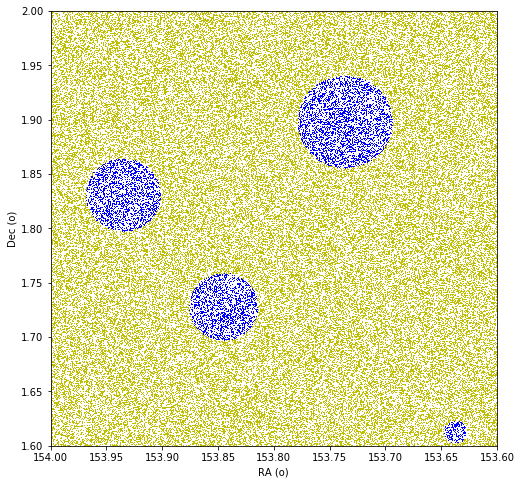

In [131]:
plt.figure(figsize=(8,8))
plt.axis([154,153.6,1.6,2])
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.plot(masked["RA"],masked["DEC"],'b,')
plt.plot(notmasked["RA"],notmasked["DEC"],'y,')

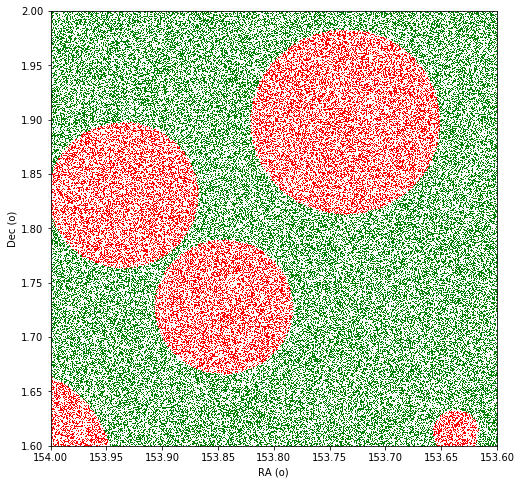

In [132]:
plt.figure(figsize=(8,8))
plt.axis([154,153.6,1.6,2])
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.plot(near["RA"],near["DEC"],'r,')
plt.plot(notnear["RA"],notnear["DEC"],'g,')

These plots of the masked random points can be compared to the shape of the masks themselves:

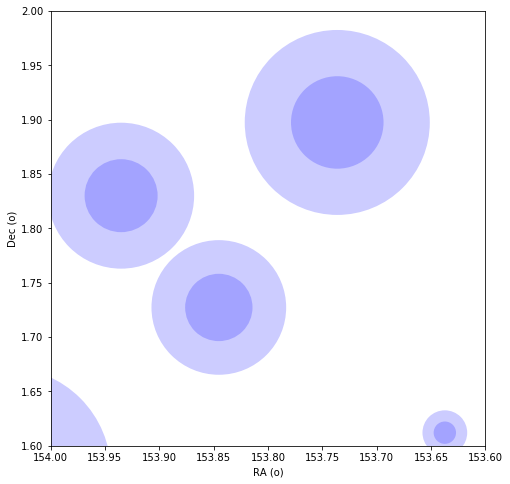

In [133]:
brightstar.plot_mask(starmask,limits=[154,153.6,1.6,2],radius="NEAR_RADIUS",show=False)
brightstar.plot_mask(starmask,limits=[154,153.6,1.6,2],radius="IN_RADIUS",over=True)